# Object Detection with Feature Extraction

By Peyman Hashemi

Jan 2023

### Imports

In [1]:
from datasetGenerator import DatasetGenerator
from dataLoader import DataLoader
import numpy as np
import skimage
import pandas as pd
import matplotlib.pyplot as plt
from utils import *
import cv2
import seaborn as sns; sns.set(); sns.set_style('dark')
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def disp(img, title='', s=8, vmin=None, vmax=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def before_after(img_a, img_b, name='', vmin=None, vmax=None, effect_name='Processed'):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f'{name} Original')
    axs[1].set_title(f'{name} {effect_name}')
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()

takes 40 seconds to run

In [ ]:
"""Get the dataset and extract features"""
dl = DataLoader("../dataset/")
dg = DatasetGenerator(dl)
"""This method is relatively slow. You can download pre-computed dataset here
https://drive.google.com/file/d/1SGJWgt3z6S44uo6GI9sFuX_WGvOoZ-8z/view?usp=sharing
"""
# Automatically loads the saved dataset if it exists
dg.prepareDataset()
f1, t1, t2, image_rois = dg.extract_features_targets_pairs()


## shuffle f1, t1, t2

In [ ]:
p = np.random.permutation(len(f1))
f1 = np.array(f1)[p]
t1 = np.array(t1)[p]
t2 = np.array(t2)[p]

In [ ]:
"""Delete features with NaN values"""
f1, t1, t2 = np.array(f1), np.array(t1), np.array(t2)
print(f1.shape, t1.shape, t2.shape)
f1 = pd.DataFrame(f1)
nan = f1.isnull().any(axis=1)
f1 = f1[~nan]
t1 = t1[~nan]
t2 = t2[~nan]
print(f1.shape, t1.shape, t2.shape)

(6141, 16) (6141,) (6141, 4)
(6141, 16) (6141,) (6141, 4)


## lil viz

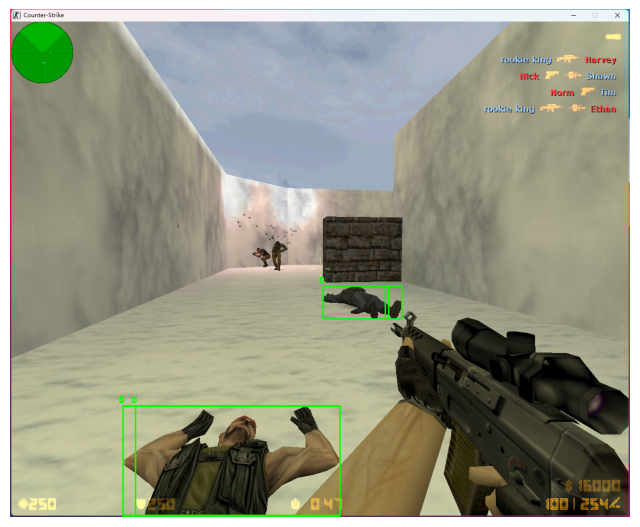

In [6]:
id = 12
image = rgb(cv2.imread("../"+dg.image_paths[id]))
image_drawn = image.copy()
candidates = dg.rois[id]

# Color and text for each class of  object
colors = [(255,255,255), (0,0,255), (0,255,0), (255,0,0), (255,255,0)]
id_texts = ["bg", "C", "D", "T", "W"]
classes = dg.classes[id]
# draw candidates
for candidate_id, candidate in enumerate(candidates):
    class_id = int(dg.classes[id][candidate_id])
    if class_id == 0:
        continue
    cv2.rectangle(image_drawn, (candidate[0], candidate[1]), (candidate[2], candidate[3]), colors[class_id], 2)
    cv2.putText(image_drawn, id_texts[class_id], (candidate[0]-8, candidate[1]-8), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[class_id], 2)
disp(image_drawn)

## data analysis

Number of training images: 193
Number of candidates: 244,706
Average number of candidates per image: 1267.91


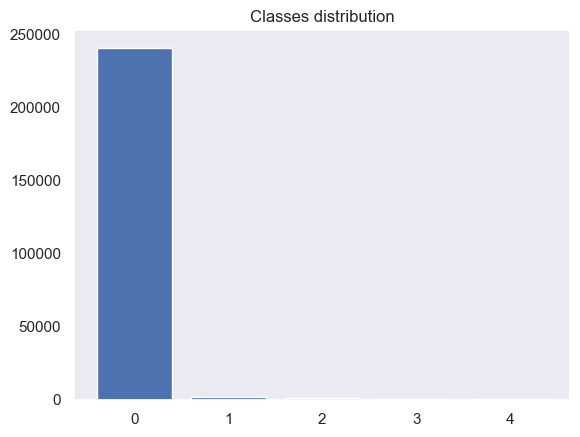

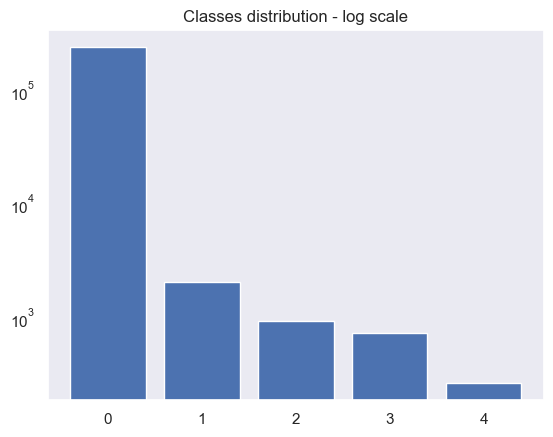

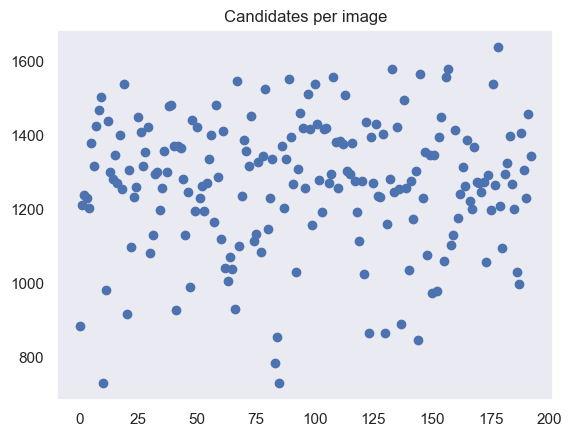

In [7]:
num_train_images = len(dg.classes)
candidate_counts = [len(c) for c in dg.classes]
num_candidates = sum(candidate_counts)
classes_counts = [0,0,0,0,0]
for c in dg.classes:
    for c_id in c:
        classes_counts[int(c_id)] += 1

print(f"Number of training images: {num_train_images}")
print(f"Number of candidates: {num_candidates:,}")
print(f"Average number of candidates per image: {num_candidates/num_train_images:.2f}")

plt.title("Classes distribution")
plt.bar(range(5), classes_counts)
plt.show()

plt.title("Classes distribution - log scale")
plt.yscale('log')
plt.bar(range(5), classes_counts)
plt.show()

plt.title("Candidates per image")
plt.scatter(range(num_train_images), candidate_counts)
plt.show()

In [8]:
len(t1)

6141

### Percentage of each class

In [9]:
values, counts = np.unique(t1, return_counts=True)
print(values)
print(counts)
print(counts/counts.sum())

['0' '1' '2' '3' '4']
[2900 1641  715  681  204]
[0.47223579 0.26722032 0.11643055 0.11089399 0.03321935]


### Histogram of training labels

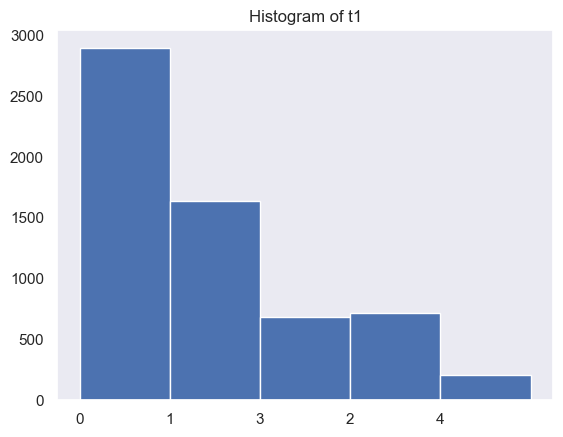

In [10]:
# Plot the histogram of t1
plt.title("Histogram of t1")
plt.hist(t1, bins=[0,1,2,3,4,5])
plt.show()


## a few rois

8 class: C [-3 -1 -6  1] (100, 59)


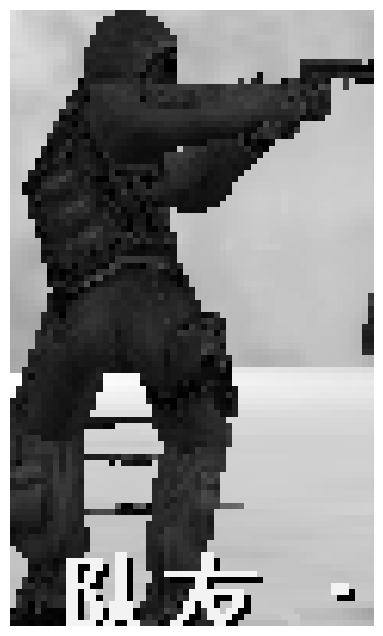

9 class: C [ 10  -5 -44   1] (359, 222)


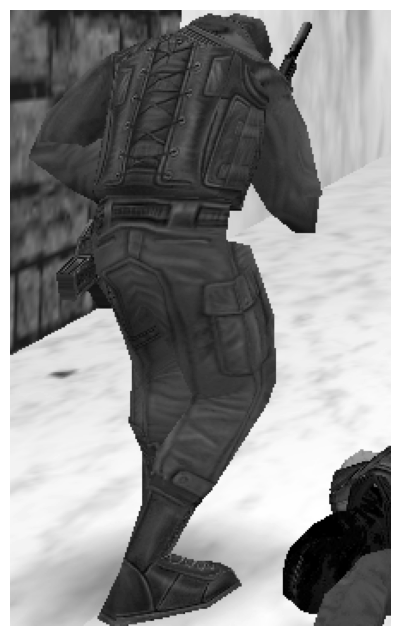

10 class: C [-7 -1  0  4] (169, 69)


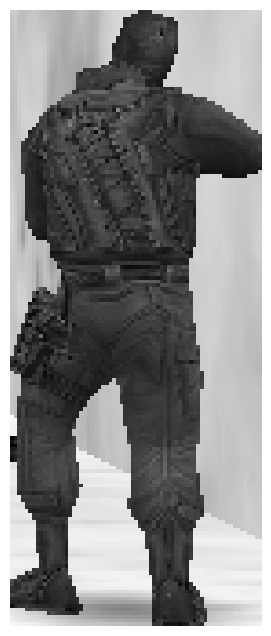

12 class: T [-1  0  2  1] (366, 152)


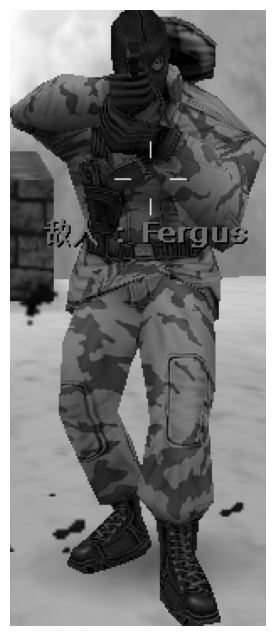

14 class: C [ 9  1  3 42] (451, 251)


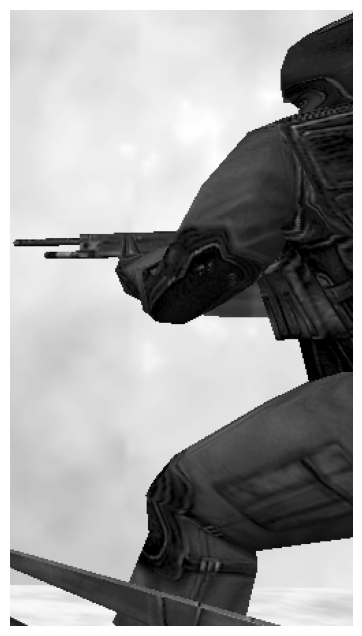

16 class: T [ 71   0 -31   2] (501, 346)


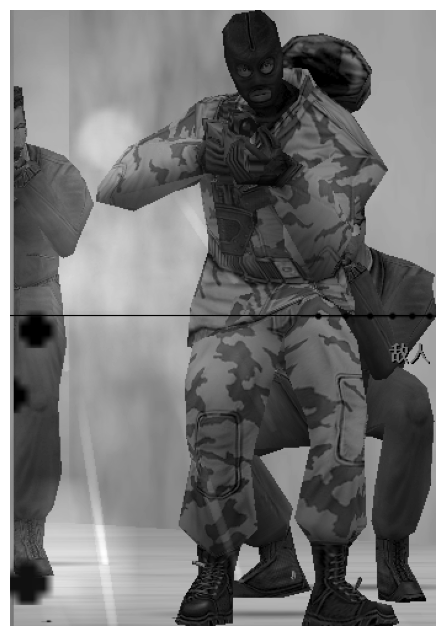

17 class: T [22  0 -6  1] (366, 183)


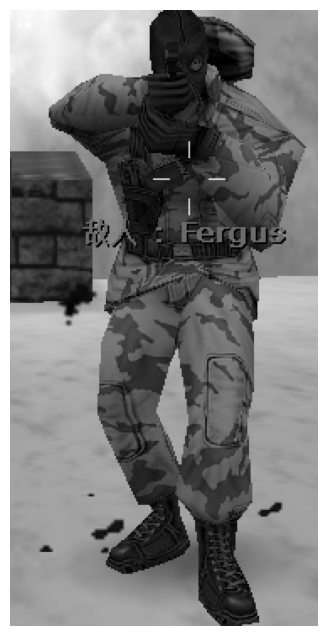

18 class: C [  3 -15  -9   6] (114, 88)


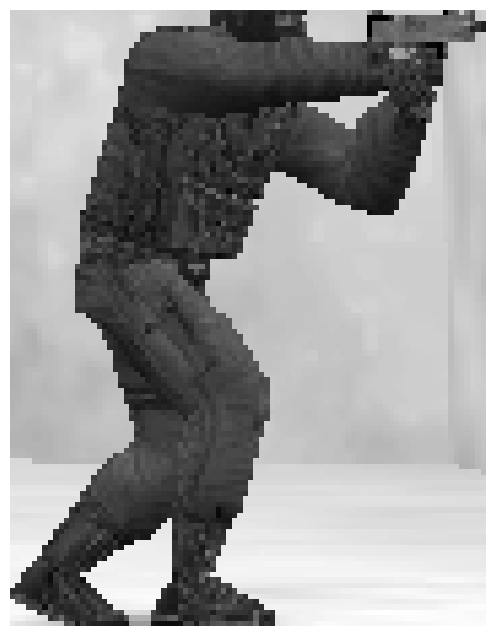

19 class: C [ 6  0 -7  4] (135, 68)


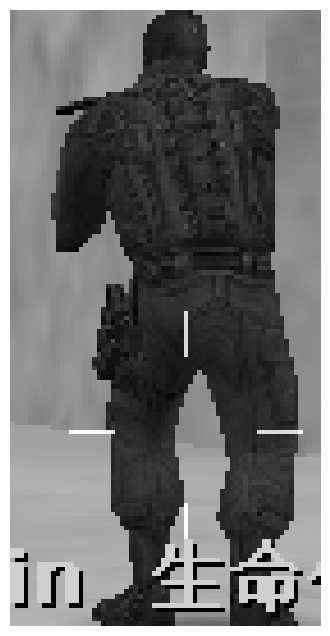

21 class: T [22  0 -6  1] (366, 183)


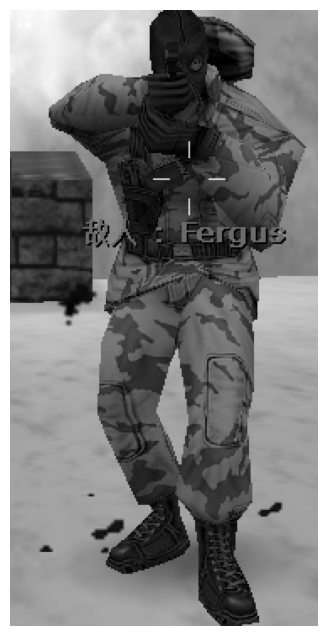

22 class: C [-2 -3 -2  3] (270, 182)


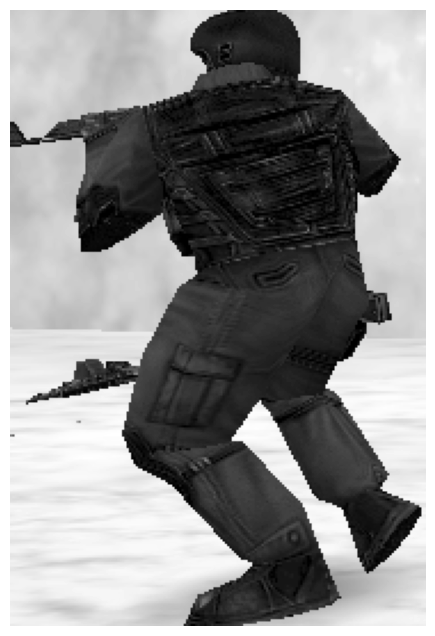

In [ ]:
class_texts = ["bg", "C", "D", "T", "W"]
shown_count = 0
for i in range(len(f1)):
    if t1[i] == '0':
        continue
    print(i, "class:", class_texts[int(t1[i])], t2[i], f1[i].shape)
    disp(f1[i])
    shown_count += 1
    if shown_count > 10:
        break

In [ ]:
from skimage.feature import local_binary_pattern
def view_lbp_hist(img):
    radius = 2
    n_points = 8 * radius
    lbp = local_binary_pattern(img, n_points, radius, 'uniform')
    n_bins = int(lbp.max() + 1)
    plt.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')
    plt.show()

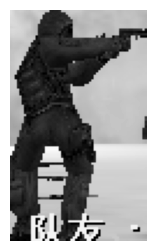

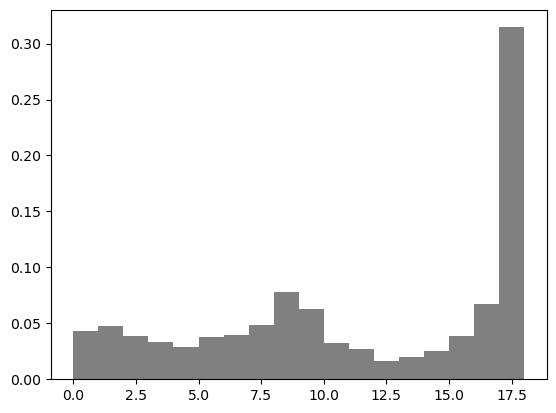

In [ ]:
disp(f1[8], s=3)
view_lbp_hist(f1[8])


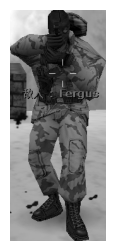

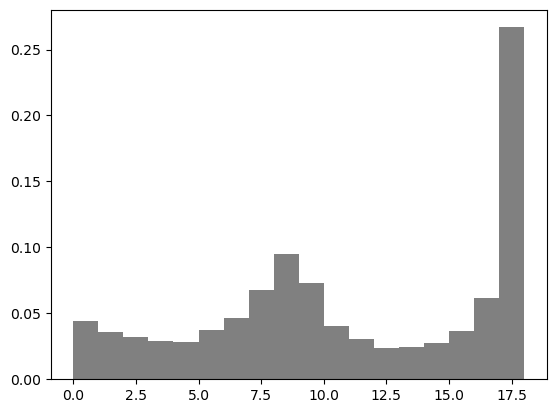

In [ ]:
disp(f1[12], s=3)
view_lbp_hist(f1[12])


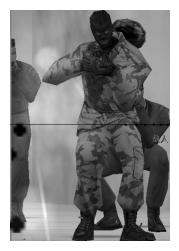

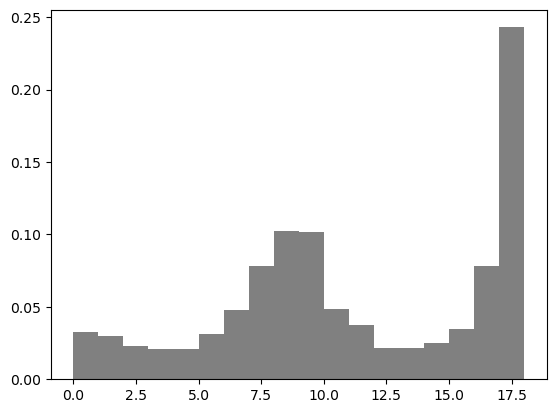

In [ ]:
disp(f1[16], s=3)
view_lbp_hist(f1[16])


In [ ]:
f1[0].min(), f1[2].max()

(0.0, 0.6618599999999999)

## Save Images to create a proposals dataset

This was used to train a model outside of this notebook. this cell saved all the roi images to a folder.

In [ ]:
class_texts = ["bg", "C", "D", "T", "W"]
shown_count = 0
for i in range(len(f1)):
    if t1[i] == '4':
        cv2.imwrite(f"../dataset/proposals/w/w_{i}.png", bgr((f1[i]*255).astype(np.uint8)))
        shown_count += 1
        if shown_count > 100:
            break

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(f1, t1, test_size=0.33, random_state=42)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

#Report shapes
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)


X_train shape:  (4114, 16)
y_train shape:  (4114,)
X_test shape:  (2027, 16)
y_test shape:  (2027,)


In [ ]:
convert y to int
y_train

array(['0', '1', '2', ..., '0', '3', '0'], dtype='<U1')

## Feature Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## T-SNE

In [13]:
# visualize X_train using t-sne
from sklearn.manifold import TSNE
import matplotlib
tsne = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=300, verbose=1)
X_train_tsne = tsne.fit_transform(X_train)
colors = np.array(['gray', 'blue', 'green', 'red', 'yellow'])
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=colors[list(map(int, y_train))])
plt.show()


(array([1919.,  480.,  451., 1133.,  131.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

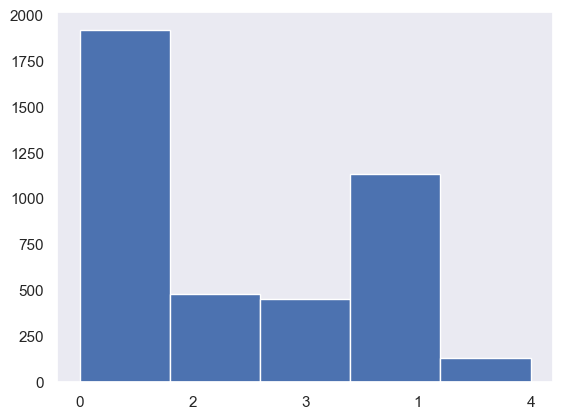

In [14]:
# y_train hist
plt.hist(y_train, bins=5)

## Train a Classifier

In [ ]:

# SVM
# from sklearn.svm import SVC
# clf = SVC(gamma='auto', verbose=True, kernel="linear")

In [ ]:
##Random Forest
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

# Gradient Boosting
# from sklearn.ensemble import GradientBoostingClassifier
# clf = GradientBoostingClassifer()

In [ ]:
# Define a Scikit-learn Classifier and train it
# KNN
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=1)

print("> Training ...")
clf.fit(X_train, y_train)
print("> Training Done!")
print("> Score: ", clf.score(X_test, y_test))

> Training ...
> Training Done!
> Score:  0.9615194869264924


In [ ]:
a = clf.predict(X_train)
np.unique(a, return_counts=True)

(array(['0', '1', '2', '3', '4'], dtype='<U1'),
 array([1953, 1079,  499,  450,  133], dtype=int64))

## Report

In [17]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       981
           1       0.95      0.99      0.97       508
           2       0.92      0.99      0.95       235
           3       0.94      0.98      0.96       230
           4       0.90      0.95      0.92        73

    accuracy                           0.96      2027
   macro avg       0.94      0.97      0.95      2027
weighted avg       0.96      0.96      0.96      2027



In [18]:
class_names = ["bg", "C", "D", "T", "W"]

<AxesSubplot:title={'center':'Confusion Matrix'}>

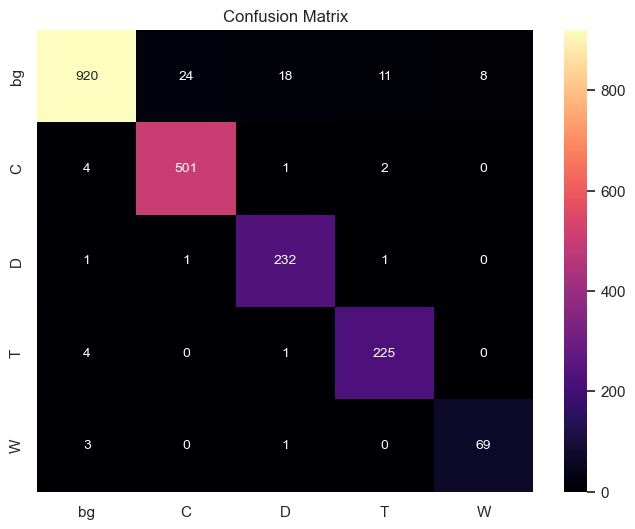

In [19]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(8,6))
plt.title('Confusion Matrix')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='magma', cbar=True, xticklabels=class_names, yticklabels=class_names, annot_kws={'size': 10})

## Extra

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

In [9]:
def rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def disp(img, title='', s=8, vmin=None, vmax=None):
    plt.figure(figsize=(s,s))
    plt.axis('off')
    if vmin is not None and vmax is not None:
        plt.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

def uint8ify(img):
    img -= img.min()
    img /= img.max()
    img *= 255
    return np.uint8(img)

def overlay(a,b):
    # a and b should be float images and between 0-1

    mask = a >= 0.5 # generate boolean mask of everywhere a > 0.5 
    ab = np.zeros_like(a) # generate an output container for the blended image 

    # now do the blending 
    ab[~mask] = (2*a*b)[~mask] # 2ab everywhere a<0.5
    ab[mask] = (1-2*(1-a)*(1-b))[mask] # else this
    
    return ab

def before_after(img_a, img_b, name='', vmin=None, vmax=None, effect_name='Processed'):
    fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,4))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f'{name} Original')
    axs[1].set_title(f'{name} {effect_name}')
    if vmin is not None and vmax is not None:
        axs[0].imshow(img_a, cmap='gray', vmin=vmin, vmax=vmax)
        axs[1].imshow(img_b, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs[0].imshow(img_a, cmap='gray')
        axs[1].imshow(img_b, cmap='gray')
    plt.show()

In [8]:
import time

class Timer():
    def __init__(self):
        self.start = time.time()
        self.elapsed = None

    def tick(self):
        self.elapsed = time.time() - self.start
        print(f">> Elapsed: {self.elapsed:.2f} seconds")
        self.start = time.time()

In [11]:
from joblib import Parallel, delayed

## Testing

70 seconds to run on 1 core for 1 image

200+ seconds to run on 16 cores

In [12]:
print("# of test images:", len(list(dl.getAllTestData())))

# of test images: 11


### Extract features and predict a class for each candidate and save them

In [ ]:
from skimage.color import rgba2rgb, rgb2gray
"""
Object detection on test images
"""
test_features_list = []
test_candidates_list = []
test_classes_list = []

index = 1
for image in dl.getAllTestData():
    ## load image
    print("--- image {index} ---".format(index=index))
    img_gray = rgb2gray(image)
    timer = Timer()

    ## Extract candidates
    print("> Extracting candidates ...")
    candidates = extract_candidates(image)
    test_candidates_list.append(candidates)
    print("Candidates: ",len(candidates))
    timer.tick()

    ## Extract features of each candidate(ROI)
    print("> Extracting features for each candidate ...")
    features = []

    '''Parallel'''
    # features = Parallel(n_jobs=-1)([delayed(dg.extract_features_roi)(img_gray, candidate) for candidate in candidates])

    '''Sequential'''
    for candidate in candidates: 
        features.append(dg.extract_features_roi(img_gray, candidate))
    test_features_list.append(features)

    ## Predict test classes
    classes = clf.predict(features)
    print(np.unique(classes, return_counts=True))
    test_classes_list.append(classes.copy())

    timer.tick()
    print()
    index += 1


--- image 1 ---
> Extracting candidates ...
Candidates:  939
>> Elapsed: 18.62 seconds
> Extracting features for each candidate ...
(array(['0', '1', '2', '3', '4'], dtype='<U1'), array([773,  19,  83,  34,  30], dtype=int64))
>> Elapsed: 50.34 seconds

--- image 2 ---
> Extracting candidates ...
Candidates:  746
>> Elapsed: 15.21 seconds
> Extracting features for each candidate ...
(array(['0', '1', '2', '3', '4'], dtype='<U1'), array([700,  30,   7,   7,   2], dtype=int64))
>> Elapsed: 87.19 seconds

--- image 3 ---
> Extracting candidates ...
Candidates:  555
>> Elapsed: 12.26 seconds
> Extracting features for each candidate ...
(array(['0', '1', '2', '3', '4'], dtype='<U1'), array([521,   7,   6,   2,  19], dtype=int64))
>> Elapsed: 29.30 seconds

--- image 4 ---
> Extracting candidates ...
Candidates:  753
>> Elapsed: 14.65 seconds
> Extracting features for each candidate ...
(array(['0', '1', '2', '3', '4'], dtype='<U1'), array([660,  62,   3,  25,   3], dtype=int64))
>> Elapsed:

Save test_features and test_candidates and test_classes

In [26]:
# np.save("test_features_list.npy", test_features_list)
# np.save("test_candidates_list.npy", test_candidates_list)
# np.save("test_classes_list.npy", test_classes_list)

c:\Users\gholamreza\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Load features and candidates for testing (uncomment)

In [4]:
# test_features_list = np.load("test_features_list.npy", allow_pickle=True)
# test_candidates_list = np.load("test_candidates_list.npy", allow_pickle=True)
# test_classes_list = np.load("test_classes_list.npy", allow_pickle=True)

In [13]:
len(test_classes_list[4])

799

In [14]:
test_classes_list[2]

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '4', '0', '0', '0', '0', '0', '0', '0', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '4', '0', '0',
       '0', '0', '0', '4', '1', '1', '1', '1', '0', '0', '1', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '0', '0', '0', '2', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '3', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '3', '0', '0', '0', '2', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '2',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '4',
       '4', '4', '0', '0', '0', '0', '2', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '2', '0', '2', '4', '0', '0', '0

939

Draw each box sequentially

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- image 0 ---
Bad Candidates:  154


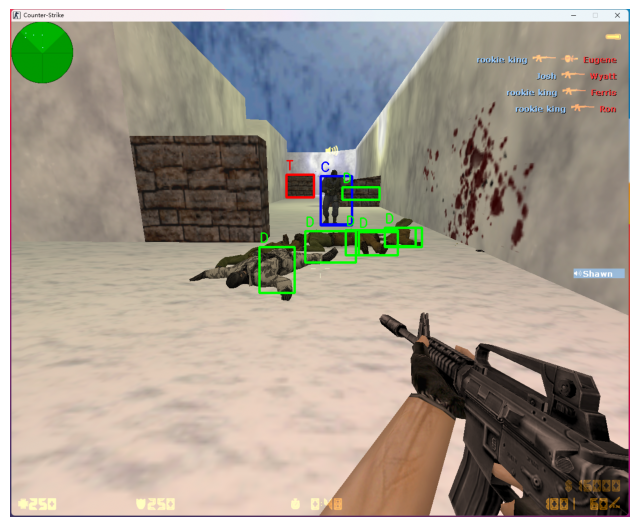

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- image 1 ---
Bad Candidates:  35


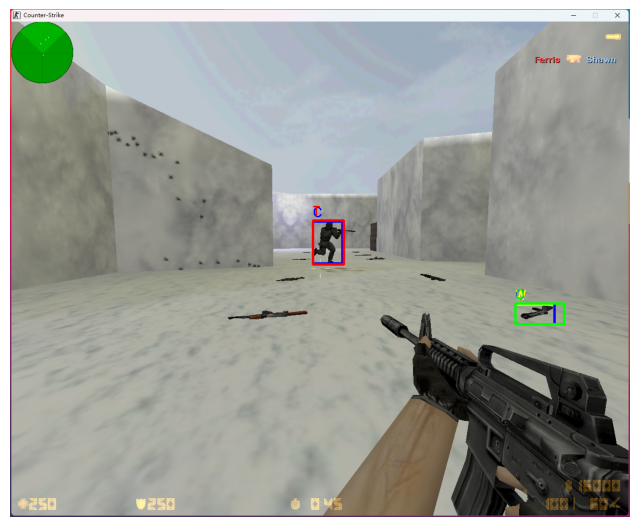

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- image 2 ---
Bad Candidates:  33


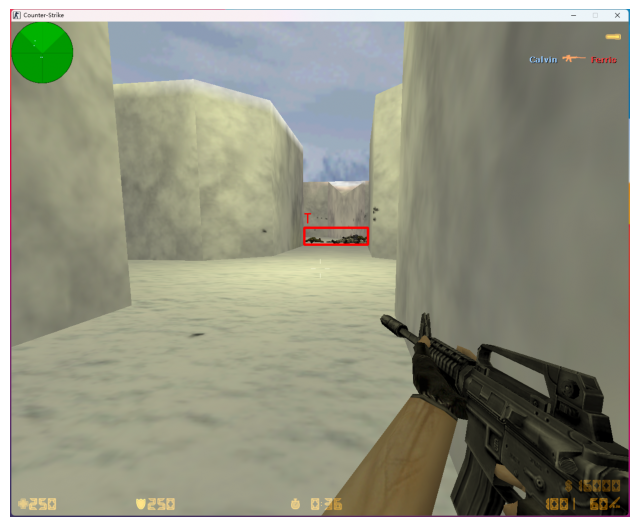

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- image 3 ---
Bad Candidates:  86


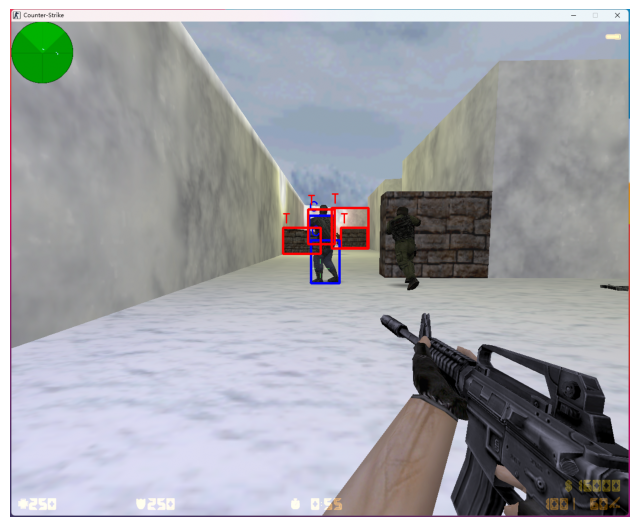

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- image 4 ---
Bad Candidates:  94


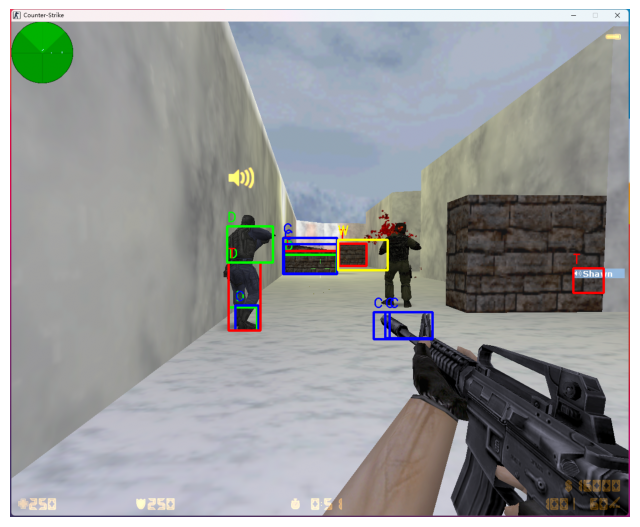

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- image 5 ---
Bad Candidates:  111


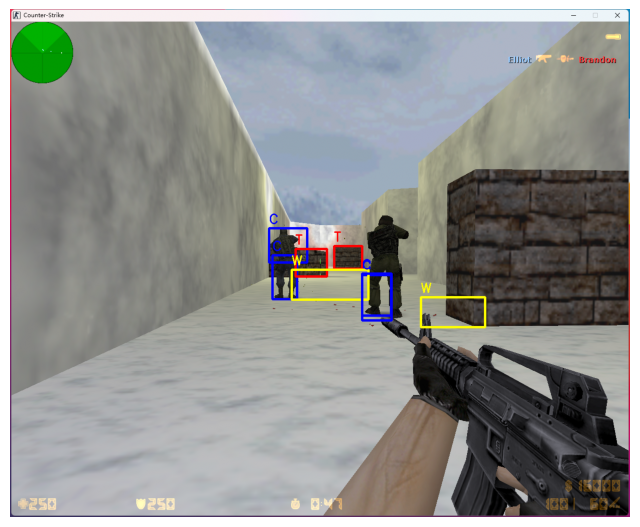

--- image 6 ---
Bad Candidates:  19


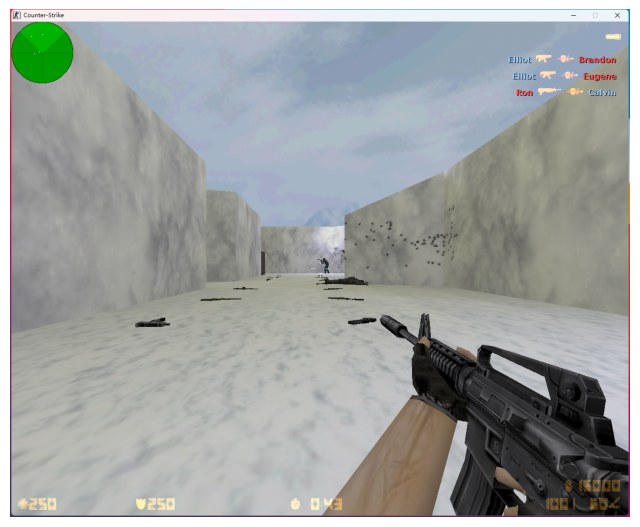

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- image 7 ---
Bad Candidates:  104


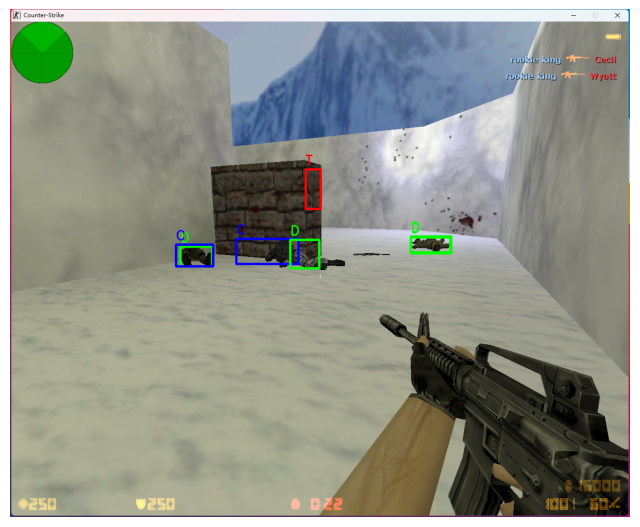

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- image 8 ---
Bad Candidates:  25


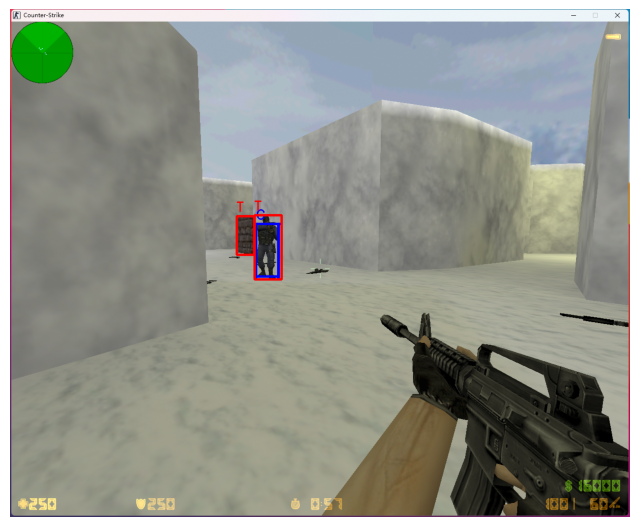

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- image 9 ---
Bad Candidates:  38


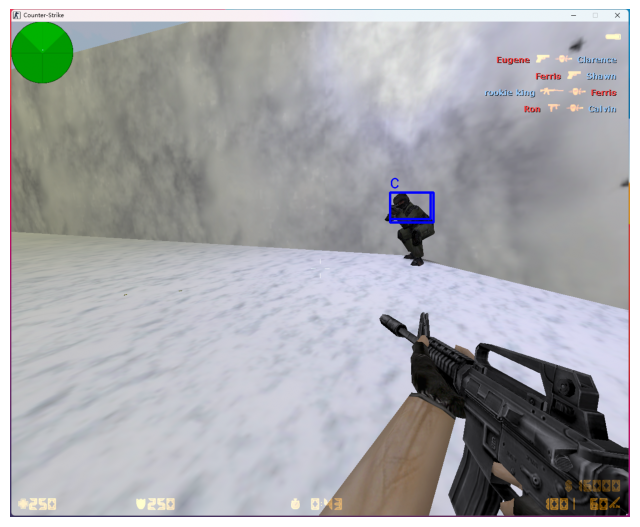

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- image 10 ---
Bad Candidates:  64


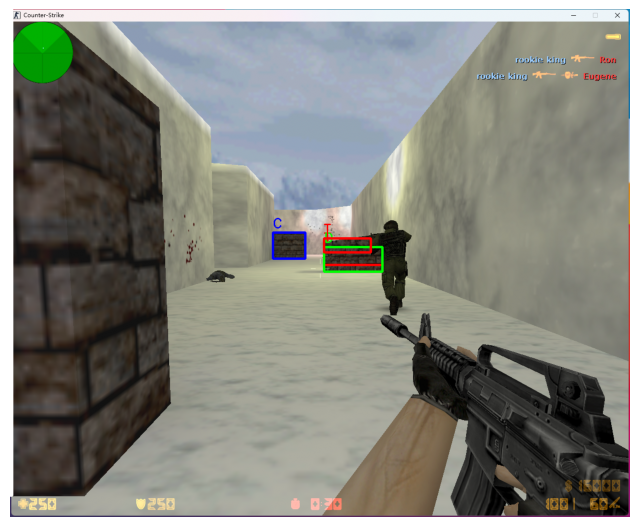

In [15]:
from skimage.color import rgba2rgb, rgb2gray
"""
Object detection on test images
"""
index = 0

for image in dl.getAllTestData():
    print("--- image {index} ---".format(index=index))
    img_gray = rgb2gray(image)
    timer = Timer()

    features = np.array(test_features_list[index])
    candidates = np.array(test_candidates_list[index])
    classes = np.array(test_classes_list[index])

    # Color and text for each class of  object
    colors = [(255,255,255), (0,0,255), (0,255,0), (255,0,0), (255,255,0)]
    id_texts = ["bg", "C", "D", "T", "W"]

    # Show Bounding Boxes with their classes.
    # print("> PLotting Predictions ...")
    bad_counter = 0
    for i in range(len(classes)):
        if int(classes[i]) == 0:
            continue

        # import pdb; pdb.set_trace()
        x1,y1,x2,y2 = candidates[i,:]
        color = colors[int(classes[i])]
        text = id_texts[int(classes[i])]
        
        # if the reactangle is too small, ignore it
        A = (x2-x1)*(y2-y1)
        if A < 100:
            bad_counter += 1
            continue

        # if the rectangle is too big, ignore it
        if A > 10000:
            bad_counter += 1
            continue

        # if the rectangle is too wide, ignore it
        if (x2-x1)/(y2-y1) > 4:
            bad_counter += 1
            continue

        # if the rectangle is too tall, ignore it
        if (y2-y1)/(x2-x1) > 4:
            bad_counter += 1
            color=(100, 100, 100)#continue

        # ignore the rectangle if it is too close to the bottom right corner
        if x2 > 0.55*image.shape[1] and y2 > 0.65*image.shape[0]:
            bad_counter += 1
            continue#color=(100, 100, 100)#continue


        # print(classes[i])

        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 3)
        
        cv2.putText(image, text, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    print("Bad Candidates: ", bad_counter)
        
    # timer.tick()
    disp(image)
    index += 1
    # break